In [3]:
import json
from collections import Counter

class Deck:
    def __init__(self, info):
        self.name = info['deckName'][0]
        self.hero = info['hero'][0]
        self.cards = Counter()
        for name, [count] in info['cards'].items():
            self.cards[name] = count

training_path = 'data/trainingDecks.json'
test_path = 'data/testDecks.json'
            
def get_decks_dict(path):
    decks_dict = dict()    
    
    with open(path, 'r') as decks:
        for line in decks.readlines():
            json_info = json.loads(line)
            decks_dict[json_info['deckName'][0]] = Deck(json_info)
    return decks_dict

training_decks = get_decks_dict(training_path)
test_decks = get_decks_dict(test_path)

In [4]:
import pandas as pd
training_games = pd.read_csv('data/training_games.csv', delimiter=';', 
                             names=['id', 'bot1', 'deck1', 'bot2', 'deck2', 'result'])
print(training_games['result'].value_counts())

PLAYER_0 WON    165347
PLAYER_1 WON    134333
Name: result, dtype: int64


In [5]:
import pandas as pd
training_games = pd.read_csv('data/training_games.csv', delimiter=';', 
                             names=['id', 'bot1', 'deck1', 'bot2', 'deck2', 'result'])
training_games['result'] = training_games['result'] == 'PLAYER_1 WON'
training_games['result'] = training_games['result'].astype(int)
print(training_games.head())
print(len(training_games))

         id bot1       deck1 bot2       deck2  result
0  100001.0   A1  deck113225   A1  deck731599       0
1  100002.0   A1  deck694943   A1  deck929572       1
2  100003.0   A1  deck182567   A1  deck525929       0
3  100004.0   A1  deck219364   A1  deck757429       1
4  100005.0   A1  deck826229   A1  deck337123       1
299680


In [6]:
training_hero = training_games
training_hero['hero1'] = training_hero.apply(lambda row: training_decks[row['deck1']].hero, axis=1)
training_hero['hero2'] = training_hero.apply(lambda row: training_decks[row['deck2']].hero, axis=1)
print(training_hero.head())

         id bot1       deck1 bot2       deck2  result    hero1    hero2
0  100001.0   A1  deck113225   A1  deck731599       0   Priest    Druid
1  100002.0   A1  deck694943   A1  deck929572       1   Shaman  Paladin
2  100003.0   A1  deck182567   A1  deck525929       0    Rogue  Paladin
3  100004.0   A1  deck219364   A1  deck757429       1  Warlock  Paladin
4  100005.0   A1  deck826229   A1  deck337123       1     Mage  Paladin


In [7]:
heros = {deck.hero for deck in training_decks.values()}
print(heros)

{'Hunter', 'Rogue', 'Shaman', 'Warrior', 'Priest', 'Paladin', 'Mage', 'Warlock', 'Druid'}


### Let's look at the cards

In [8]:
test_heros = {deck.hero for deck in test_decks.values()}
print(test_heros)

{'Hunter', 'Rogue', 'Shaman', 'Warrior', 'Paladin', 'Mage', 'Warlock', 'Druid', 'Priest'}


In [9]:
train_cards = set()
test_cards = set()
for deck in training_decks.values():
    train_cards.update(deck.cards.keys())

for deck in test_decks.values():
    test_cards.update(deck.cards.keys())

In [10]:
print(train_cards)
print(test_cards)

{'Lightning Bolt', 'Archmage', 'Northshire Cleric', 'Lost Tallstrider', 'Hammer of Wrath', 'Jade Behemoth', 'Hooked Reaver', 'Fan of Knives', 'Nightblade', 'Mistress of Mixtures', 'Malfurion the Pestilent', 'Druid of the Fang', 'Nourish', 'Dragonfire Potion', 'Mind Blast', 'Kobold Librarian', 'Bite', 'Drakonid Operative', 'Candleshot', "Sorcerer's Apprentice", 'Prince Taldaram', 'Darkshire Librarian', 'Archmage Antonidas', 'Leeroy Jenkins', 'Twisted Worgen', 'Vulgar Homunculus', 'Fearsome Doomguard', 'Reckless Rocketeer', 'Brawl', 'Magma Rager', 'Ironfur Grizzly', 'Dread Infernal', "Assassin's Blade", 'Kabal Talonpriest', 'Mana Wyrm', 'River Crocolisk', 'Siphon Soul', 'Shiv', 'Stormpike Commando', 'Flametongue Totem', 'Bog Creeper', 'Aya Blackpaw', 'Mark of the Lotus', 'Unidentified Shield', "Sen'jin Shieldmasta", 'Rockpool Hunter', 'Frost Nova', 'Lost in the Jungle', 'Succubus', 'Acolyte of Pain', 'Cleave', 'Shield Block', 'Captured Jormungar', 'Bloodfen Raptor', "Light's Justice", 'A

In [11]:
print(len(test_cards), len(train_cards))

313 330


In [12]:
all_cards = test_cards.intersection(train_cards)
print(len(all_cards))

295


In [13]:
train_df = training_games.get(['bot1', 'deck1', 'result']).rename(index=str, columns={'bot1': 'player', 'deck1': 'deck'})
train_df['result'] = 1 - train_df['result']
train_df = train_df.append([training_games.get(['bot2', 'deck2', 'result']).rename(index=str, columns={
    'bot2': 'player', 'deck2': 'deck'})])
train_df = train_df.groupby(['player', 'deck'])['result'].mean()
train_df = train_df.reset_index()
print(train_df.head())

  player        deck    result
0     A1  deck100087  0.291667
1     A1  deck101443  0.276627
2     A1  deck102280  0.550613
3     A1  deck104259  0.404459
4     A1  deck105300  0.397929


In [14]:
train_df2 = training_hero.get(['bot1', 'deck1', 'result', 'hero2']).rename(index=str,
                            columns={'bot1': 'player', 'deck1': 'deck', 'hero2': 'enemy'})
train_df2['result'] = 1 - train_df2['result']
train_df2 = train_df2.append([training_hero.get(['bot2', 'deck2', 'result', 'hero1']).rename(index=str, columns={
    'bot2': 'player', 'deck2': 'deck', 'hero1': 'enemy'})])
train_df2 = train_df2.groupby(['player', 'deck', 'enemy'])['result'].mean()
train_df2 = train_df2.reset_index()
print(train_df2.head(20))

   player        deck    enemy    result
0      A1  deck100087    Druid  0.409836
1      A1  deck100087   Hunter  0.271845
2      A1  deck100087     Mage  0.469697
3      A1  deck100087  Paladin  0.127273
4      A1  deck100087   Priest  0.363636
5      A1  deck100087    Rogue  0.333333
6      A1  deck100087   Shaman  0.226415
7      A1  deck100087  Warlock  0.179487
8      A1  deck100087  Warrior  0.533333
9      A1  deck101443    Druid  0.406780
10     A1  deck101443   Hunter  0.159091
11     A1  deck101443     Mage  0.387755
12     A1  deck101443  Paladin  0.196721
13     A1  deck101443   Priest  0.349206
14     A1  deck101443    Rogue  0.176471
15     A1  deck101443   Shaman  0.368421
16     A1  deck101443  Warlock  0.202247
17     A1  deck101443  Warrior  0.537037
18     A1  deck102280    Druid  0.612245
19     A1  deck102280   Hunter  0.387097


### Card names one hot encoding

In [15]:
def intersect_with_test_cards(cards_dict):
    keys = test_cards.intersection(cards_dict)
    return {k:cards_dict[k] for k in keys} 

In [16]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
D = [deck.cards for deck in training_decks.values()]
X = v.fit_transform(D)

In [17]:
import numpy as np

heros_arr2 = np.zeros((len(train_df2['deck']), len(test_heros)))

for i, deck_name in enumerate(train_df2['deck']):
    for j, hero in enumerate(test_heros):
        heros_arr2[i, j] = training_decks[deck_name].hero == hero

enemy_arr = np.zeros((len(train_df2['deck']), len(test_heros)))

for i, enemy in enumerate(train_df2['enemy']):
    for j, hero in enumerate(test_heros):
        enemy_arr[i, j] = enemy == hero

print(enemy_arr.shape)
print(heros_arr2.shape)

(14400, 9)
(14400, 9)


In [18]:
import numpy as np

heros_arr = np.zeros((len(train_df['deck']), len(test_heros)))

for i, deck_name in enumerate(train_df['deck']):
    for j, hero in enumerate(test_heros):
        heros_arr[i, j] = training_decks[deck_name].hero == hero

In [19]:
ai_rates_df = (training_games.groupby(['bot1'])['result'].mean() + 1 - training_games.groupby(['bot2'])['result'].mean()) / 2
ai_rates_dict = ai_rates_df.to_dict()
print(ai_rates_dict)

{'A1': 0.54794083877250188, 'A2': 0.48449577954254092, 'B2': 0.44216063484566098, 'B1': 0.45799675245171284}


In [20]:
ai_rates_df2 = (training_games.groupby(['bot1'])['result'].mean() + 1 - training_games.groupby(['bot2'])['result'].mean()) / 2
ai_rates_dict2 = ai_rates_df2.to_dict()
print(ai_rates_dict)

{'A1': 0.54794083877250188, 'A2': 0.48449577954254092, 'B2': 0.44216063484566098, 'B1': 0.45799675245171284}


In [21]:
import numpy as np

players = ['A1', 'A2', 'B1', 'B2']

players_features = [(train_df['player'] == pl).as_matrix() for pl in players]
players_rates = np.array([ai_rates_dict[pl] for pl in train_df['player']])

x = np.array([v.transform(training_decks[deck_name].cards)[0] for deck_name in train_df['deck']])

In [22]:
import numpy as np

players = ['A1', 'A2', 'B1', 'B2']

players_features2 = [(train_df2['player'] == pl).as_matrix() for pl in players]
players_rates2 = np.array([ai_rates_dict[pl] for pl in train_df2['player']])

x2 = np.array([v.transform(training_decks[deck_name].cards)[0] for deck_name in train_df2['deck']])

In [23]:
print(players_rates.reshape(-1, 1).shape)

(1600, 1)


In [24]:
print(X.shape)

(400, 330)


### Let's get some statistics for each card

In [25]:
card_stats = json.load(open('data/formatted_cards.json', 'r'))
#json.dump(card_stats, open('data/formatted_cards.json', 'w'), indent=4)

In [26]:
card_stats = [stat for stat in card_stats if 'name' in stat]

In [27]:
stats_dict = {stat['name']:stat for stat in card_stats}

In [28]:
from collections import Counter

def aggregate_results(feature, fun, decks):
    counter = Counter()

    for stat in stats_dict.values():
        if feature in stat:
            counter[stat['name']] = stat[feature]
    
    def total_val(deck):
        total = 0
        cards = []
        for card, count in deck.cards.items():
            cards += [card] * count
        cards = [stats_dict[card].get(feature, 0) for card in cards]
        return fun(cards)

    return np.array([total_val(deck) for deck in decks])

In [29]:
card_features = ['cost', 'attack', 'health'#, 'durability', 'armor'
                ]
functions = [np.mean, np.median, np.var, 
             #np.max
            ]

tr_decks = [training_decks[deck_name] for deck_name in train_df['deck']]

def get_aggregated_features(decks=tr_decks):
    features_x = []
    for feature in card_features:
        for fun in functions:
            features_x.append(aggregate_results(feature, fun, decks))
    features_x = np.array(features_x)
    return features_x

features_x = get_aggregated_features()
print(features_x.shape)
print(len(train_df))


(9, 1600)
1600


In [30]:
tr_decks2 = [training_decks[deck_name] for deck_name in train_df2['deck']]
features_x2 = get_aggregated_features(tr_decks2)
print(features_x2.shape)
print(len(train_df2))

(9, 14400)
14400


In [31]:
players_x = np.stack(players_features).T
players_rates_x = players_rates.reshape(-1, 1)
players_x2 = np.stack(players_features2).T
players_rates_x2 = players_rates2.reshape(-1, 1)

In [32]:
print(features_x.T.shape)
print(heros_arr.shape)
print(players_x.shape)
print(players_rates_x.shape)
print(x.shape)

(1600, 9)
(1600, 9)
(1600, 4)
(1600, 1)
(1600, 330)


In [33]:
print(features_x2.T.shape)
print(heros_arr2.shape)
print(enemy_arr.shape)
print(players_x2.shape)
print(players_rates_x2.shape)
print(x2.shape)

(14400, 9)
(14400, 9)
(14400, 9)
(14400, 4)
(14400, 1)
(14400, 330)


In [53]:
X = np.concatenate([x, 
                    players_x, 
                    players_rates_x,
                    players_time_x,
                    features_x.T, 
                    heros_arr
                   ], axis=1)
y = train_df['result'].as_matrix()

In [54]:
X2 = np.concatenate([x2, 
                    players_x2, 
                    players_rates_x2,
                    players_time_x2,
                    features_x2.T, 
                    heros_arr2,
                    enemy_arr
                   ], axis=1)
y2 = train_df2['result'].as_matrix()

In [41]:
print(X2.shape)
print(y2.shape)
print(y)

(14400, 363)
(14400,)
[ 0.29166667  0.27662722  0.5506135  ...,  0.56593407  0.35714286
  0.53947368]


**Statystyki o graczach**

In [1]:
import numpy as np
import json

path = 'E:\\Users\\Ryszard\\hs_jsons\\' #path to the directory with jsons

players = ['A1', 'A2', 'B1', 'B2']
def match_length(match):
    result = dict()
    length = len(match["game"])
    result[match["game_setup"]["bot_1_ply"]] = length
    result[match["game_setup"]["bot_2_ply"]] = length
    return result

def match_stats(stat_fun):
    min_id = 100001
    max_id = 399680
    stats = dict()
    for pl in players:
        stats[pl] = list()
        
    for i in range(min_id, max_id+1):
        with open(path + 'log' + str(i) + '.log') as f:
            match = json.load(f)
            result = stat_fun(match)
            for pl in result.keys():
                stats[pl].append(result[pl])
        if i%10000 == 0:
            print("Done with log number " + str(i))
    
    return stats

stats = match_stats(match_length)
for pl in players:
    print(np.mean(stats[pl]))

test
Done with log number 100100
Done with log number 100200
Done with log number 100300
Done with log number 100400
Done with log number 100500
Done with log number 100600
Done with log number 100700
Done with log number 100800
Done with log number 100900
Done with log number 101000
Done with log number 101100
Done with log number 101200
Done with log number 101300
Done with log number 101400
Done with log number 101500
Done with log number 101600
Done with log number 101700
Done with log number 101800
Done with log number 101900
Done with log number 102000
Done with log number 102100
Done with log number 102200
Done with log number 102300
Done with log number 102400
Done with log number 102500
Done with log number 102600
Done with log number 102700
Done with log number 102800
Done with log number 102900
Done with log number 103000
Done with log number 103100
Done with log number 103200
Done with log number 103300
Done with log number 103400
Done with log number 103500
Done with log n

In [52]:
stats = {"A1": 110.748014305, "A2": 108.627219977, "B1": 113.546226718, "B2": 105.622228085}
for pl in players:
    print(pl)
    print(np.mean(stats[pl]))
players_time = np.array([stats[pl] for pl in train_df['player']])
players_time2 = np.array([stats[pl] for pl in train_df2['player']])
players_time_x = players_time.reshape(-1, 1)
players_time_x2 = players_time2.reshape(-1, 1)

A1
110.748014305
A2
108.627219977
B1
113.546226718
B2
105.622228085


**shufflujemy dataset**

In [55]:
import random
indices = random.sample(range(len(y)), len(y))
X = X[indices]
y = y[indices]
y *= 100
indices = random.sample(range(len(y2)), len(y2))
X2 = X2[indices]
y2 = y2[indices]
y2 *= 100

In [56]:
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import BayesianRidge, SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor


In [127]:
clf = SVR(gamma=0.001, epsilon=0.1, C=100, kernel='rbf')
gb = GradientBoostingRegressor()
gb_params = {'learning_rate': [0.3, 0.4, 0.5, 0.6, ],
            'max_depth': [3, 4],
             'n_estimators': [200, 300, 400, 500, 600]`````
            #'criterion': ['friedman_mse', 'mse'],
            #'max_features': [None, 'sqrt', 'log2']
            }

parameters = {'C': np.arange(1, 20) * 50, 
              'gamma': ['auto', 0.0005, 0.001, 0.005, 0.01, 0.02],
              'epsilon': [0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
             }

nn_params = {'hidden_layer_sizes': [(300,), (512,), (800,)]}

nn = MLPRegressor(hidden_layer_sizes=(512, ))

X_new = StandardScaler().fit_transform(X2)

grid_clf = RandomizedSearchCV(gb, gb_params, scoring='neg_mean_squared_error', cv=8, verbose=5, n_jobs=7)
grid_clf = grid_clf.fit(X_new, y2)
print(np.sqrt(-grid_clf.best_score_))
print(grid_clf.best_params_)

Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:  2.0min
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed: 36.3min
[Parallel(n_jobs=7)]: Done  80 out of  80 | elapsed: 53.7min finished


9.83869450694
{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 500}


In [42]:
import math

def reduce(x):
    x = np.array([max(val, 0) for val in x])
    return np.array([min(val, 100) for val in x])

In [107]:
print(X.shape)
#svr_classifier = SVR(gamma=0.01, epsilon=0.02, C=100)
#svr_classifier = svr_classifier.fit(X, y)
#gb_classifier = GradientBoostingRegressor(n_estimators=500, learning_rate=0.3, max_depth=3, max_features=None)
#gb_classifier = gb_classifier.fit(X, y)

svr_classifier2 = SVR(gamma=0.01, epsilon=0.02, C=100)
svr_classifier2 = svr_classifier2.fit(X2, y2)
gb_classifier2 = GradientBoostingRegressor(n_estimators=500, learning_rate=0.3, max_depth=3, max_features=None)
gb_classifier2 = gb_classifier2.fit(X2, y2)
#nn_classifier = MLPRegressor(hidden_layer_sizes=(512, ))
#nn_classifier = nn_classifier.fit(X, y)

(1600, 354)


In [108]:
def predict(deck, player, classifier, classifier2):
    players_features = [player == pl for pl in players]
    players_rates = [ai_rates_dict[player]]
    players_time = [stats[player]]

    
    heros_arr = np.zeros((len(test_heros), ))

    for j, hero in enumerate(test_heros):
        heros_arr[j] = deck.hero == hero


    heros_arr = heros_arr.reshape(-1, 1)
    players_x = np.array(players_features).reshape(-1, 1)
    players_rates_x = np.array([players_rates]).reshape(-1, 1)
    players_time_x = np.array([players_time]).reshape(-1, 1)
    features_x = get_aggregated_features([deck])
    x_test = np.array(v.transform([deck.cards]))
    x_test = x_test.reshape(-1, 1)
    X_pred = np.concatenate([x_test, 
                             players_x, 
                             players_rates_x,
                             players_time_x,
                             features_x,
                             heros_arr])
    #print(X_pred.shape)
    X_pred = X_pred.reshape(1, -1)
    preds = classifier2.predict(X_pred)# * 0.8 + classifier2.predict(X_pred) * 0.2
    return reduce(preds)

In [109]:
def predict2(deck, player, enemy, classifier, classifier2):
    players_features = [player == pl for pl in players]
    players_rates = [ai_rates_dict[player]]
    players_time = [stats[player]]
    
    
    heros_arr = np.zeros((len(test_heros), ))

    for j, hero in enumerate(test_heros):
        heros_arr[j] = deck.hero == hero
        
    enemy_arr = np.zeros((len(test_heros), ))

    for j, hero in enumerate(test_heros):
        enemy_arr[j] = enemy == hero

    heros_arr = heros_arr.reshape(-1, 1)
    enemy_arr = enemy_arr.reshape(-1, 1)
    players_x = np.array(players_features).reshape(-1, 1)
    players_rates_x = np.array([players_rates]).reshape(-1, 1)
    players_time_x = np.array([players_time]).reshape(-1, 1)
    features_x = get_aggregated_features([deck])
    x_test = np.array(v.transform([deck.cards]))
    x_test = x_test.reshape(-1, 1)
    X_pred = np.concatenate([x_test, 
                             players_x, 
                             players_rates_x,
                             players_time_x,
                             features_x,
                             heros_arr,
                             enemy_arr])
    X_pred = X_pred.reshape(1, -1)
    preds = classifier2.predict(X_pred)# * 0.8 + classifier2.predict(X_pred) * 0.2
    return reduce(preds)


In [110]:

def get_test_decks_list():
    test_decks = []

    with open(test_path, 'r') as decks:
        for line in decks.readlines():
            json_info = json.loads(line)
            test_decks.append(json_info['deckName'][0])
    return test_decks

test_decks_names = get_test_decks_list()

def dump_results():
    df_results = pd.DataFrame()
    for player in players:
        for deck_name in test_decks_names:
            deck = test_decks[deck_name]
            win_rate = predict(deck, player, svr_classifier, gb_classifier)[0]
            df_results = df_results.append({'player': player, 'deck_name': deck_name, 'win_rate': win_rate}, 
                                           ignore_index=True)

    print(df_results.head())
    df_results.to_csv('data/test_results.csv', index=False, header=False, columns=['player', 'deck_name', 'win_rate'],
                     sep=';')
    return df_results

test_heros = [deck.hero for deck in test_decks.values()]
test_hero_counts = Counter(test_heros)
hero_count = len(test_heros)
test_heros = {deck.hero for deck in test_decks.values()}

def dump_results2():
    df_results = pd.DataFrame()
    for player in players:
        for deck_name in test_decks_names:
            deck = test_decks[deck_name]
            win_rate = 0
            for enemy in heros:
                win_rate += predict2(deck, player, enemy, svr_classifier2, gb_classifier2)[0] * test_hero_counts[enemy]
            win_rate /= hero_count
            df_results = df_results.append({'player': player, 'deck_name': deck_name, 'win_rate': win_rate}, 
                                           ignore_index=True)

    print(df_results.head())
    df_results.to_csv('data/test_results3.csv', index=False, header=False, columns=['player', 'deck_name', 'win_rate'],
                     sep=';')
    return df_results

print(X.shape)
df_results = dump_results2()

(1600, 354)
    deck_name player   win_rate
0  deck244804     A1  28.908976
1  deck124802     A1  42.714740
2  deck687350     A1  37.880017
3  deck517728     A1  41.386736
4  deck130762     A1  39.476625


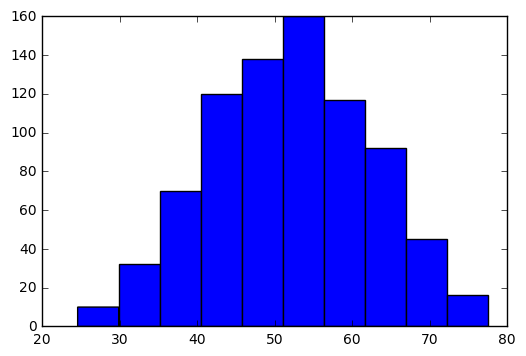

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(df_results['win_rate'])
plt.show()

In [34]:
print(np.mean(df_results['win_rate']))

51.91216582456974


In [54]:
heros = [deck.hero for deck in tr_decks]
tr_hero_counts = Counter(heros)
print(tr_hero_counts)

Counter({'Paladin': 268, 'Hunter': 264, 'Warlock': 264, 'Rogue': 144, 'Priest': 136, 'Mage': 136, 'Druid': 132, 'Warrior': 128, 'Shaman': 128})


In [47]:
test_heros = [deck.hero for deck in test_decks.values()]
test_hero_counts = Counter(test_heros)
print(test_hero_counts)

Counter({'Hunter': 33, 'Warlock': 33, 'Paladin': 32, 'Warrior': 19, 'Druid': 18, 'Shaman': 18, 'Priest': 17, 'Mage': 16, 'Rogue': 14})
200
